In [1]:
if Sys.iswindows()
    username = "Alex"
    pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
    using Pkg
    Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")
    using StaticArrays, DifferentialEquations, DynamicalSystems, BenchmarkTools, CairoMakie
        include("C:\\Users\\Alex\\Desktop\\dynamical-systems\\system.jl");
    #include("C:\\Users\\Alex\\Desktop\\dynamical-systems\\visual.jl");
else
    username = "nova"
    pathtorepo = "/home/nova/work/repo_ds/dynamical-systems"
    using Pkg
    Pkg.activate(pathtorepo * "/env/integrate/")
    using StaticArrays, DifferentialEquations, DynamicalSystems, JLD2, CairoMakie
    include("/home/nova/work/repo_ds/dynamical-systems/system.jl")
    #include("/home/nova/work/repo_ds/dynamical-systems/visual.jl")
end

  Activating project at `~/work/repo_ds/dynamical-systems/env/integrate`


TM6_glial_ECM_help (generic function with 1 method)

In [2]:
tLSE = 5000; tt = 3000; tstep = 0.001;
tol = 1e-15;
integ_set = (alg = Vern9(), adaptive = true, abstol = tol, reltol = tol);

In [47]:
param = TM6_glial_ECM_get_params();
dict, indexparams = TM6_glial_ECM_help(param);
println(indexparams);


    τ - 1, τD - 2, τF - 3, τy - 4, α - 5, αE - 6, αecm - 7, αp - 8,
    J - 9, U0 - 10, I0 - 11, ΔU0 - 12, β - 13, βecm  -14, βp - 15,
    γp - 16, ecm0 - 17, ecm1 - 18, kecm - 19, θecm - 20, p0 - 21, p1 - 22, θp - 23, kp - 24, ythr - 25, xthr - 26


In [48]:
u0 = [0.9445509341100914, 0.74116702856987, 0.7361196042973006, 0.0646914552140727, 0.15145764079879162, 0.0009327645775731449];

In [49]:
function print_index_param(ds, name_param, index_param)
    println("u0: $(current_state(ds))");
    println("$(name_param): $(current_parameters(ds)[index_param])")
end

function find_zero(Λs; tol = 1e-2)
    vec_bool = Vector{Bool}(undef, 6);
    for (index, lp) in enumerate(Λs)
        checknull=  isapprox(lp, 0.0; atol = tol);
        vec_bool[index] = checknull;
    end
    vec_of_true = findall(x->x==true, vec_bool);
    if length(vec_of_true) >=1
        return 0;
    else
        return -1;
    end;
end

function lyapunovspectrum_adapt(tands, time_lse, u0_; tol_ = 1e-2)
    coeff_adapt_time = 1;
    flag = true;

    Λs = lyapunovspectrum(tands, time_lse, u0 = u0_);
    while flag == true
        checkzero = find_zero(Λs; tol = tol_);
        if checkzero == -1
            coeff_adapt_time*=2;
            Λs = lyapunovspectrum(tands, time_lse * coeff_adapt_time*10, u0 = u0_);
        else
            flag = false;
        end
    end
    return Λs #, coeff_adapt_time;
end

lyapunovspectrum_adapt (generic function with 1 method)

In [50]:
ds= CoupledODEs(TM6_glial_ECM, u0, param, diffeq = integ_set);
tands = TangentDynamicalSystem(ds; J = TM6_glial_ECM_jac);

systems = [deepcopy(tands) for _ in 1:Threads.nthreads()-1];
pushfirst!(systems, tands);

In [43]:
len = 250;
αE_range = range(0.067, 5.0, length = len);
u0s = zeros(len, 6);
Λs = zeros(len, 6);
coeffs = zeros(len);

In [8]:
file_logs = "logs.txt";

In [9]:
function save_logs(index, u0_st, u0_loc)
    open(file_logs, "a") do file
        print(file, "index: $(index); αE: $(αE_range[index]); \n");
        print(file, "u0 start: $(u0_st); \n");
        print(file, "u0 end: $(u0_loc) \n");
        print(file, "\n");
    end
end

save_logs (generic function with 1 method)

In [10]:
for index in eachindex(αE_range)

   if index == 1
       global u0_loc = u0;
   end
   
   u0_st = u0_loc

   set_parameter!(ds, 6, αE_range[index]);
   tr, _ = trajectory(ds, tt, u0_loc);

   u0_loc = tr[end];
   u0s[index, :] = u0_loc;
   save_logs(index, tr[1], tr[end])
end

In [76]:
Threads.@threads for i in eachindex(αE_range)
    system = systems[Threads.threadid()]
    set_parameter!(system, 6, αE_range[i])
    #set_state!(system, u0s[i, :])
    Λs[i, :] = lyapunovspectrum_adapt(system, tLSE, u0s[i, :])
end

In [77]:
Λs[findfirst(x -> x == maximum(Λs[:, 1]), Λs[:, 1]) , :]

6-element Vector{Float64}:
  0.006106245367187609
 -0.0045483198936584045
 -0.24098359435787065
 -0.34845653025940493
 -0.7319173603584904
 -3.588648444680276

In [78]:
Λs[findfirst(x -> x == minimum(Λs[:, 1]), Λs[:, 1]) , :]

6-element Vector{Float64}:
 -0.008491824936096223
 -0.01488859206045697
 -0.28587781177611693
 -0.4569642791817169
 -0.6729740147070747
 -3.496062470381064

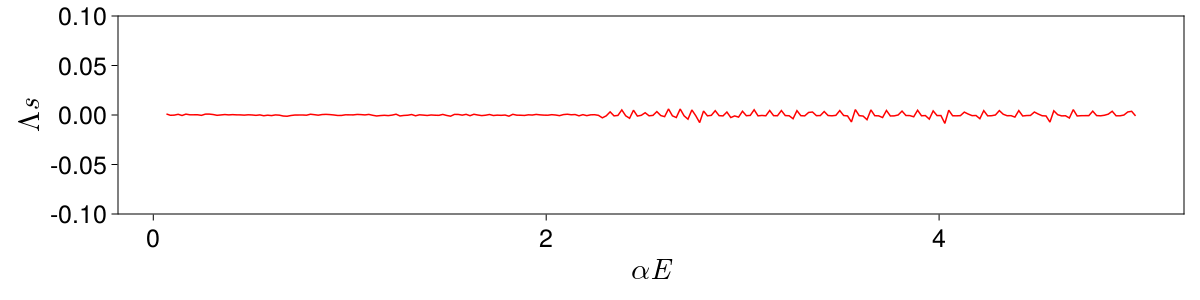

In [79]:
lb_size = 30; tck_size = 25;
lw = 1.5;
f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"αE", ylabel = L"\Lambda s",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)

lines!(axis, αE_range, Λs[:, 1], linewidth = lw, color = :red)
#=lines!(axis, αE_range, Λs[:, 2], linewidth = lw, color = :green)
lines!(axis, αE_range, Λs[:, 3], linewidth = lw, color = :deepskyblue)
lines!(axis, αE_range, Λs[:, 4], linewidth = lw, color = :slateblue1)
lines!(axis, αE_range, Λs[:, 4], linewidth = lw, color = :slateblue1)
lines!(axis, αE_range, Λs[:, 5], linewidth = lw, color = :blue)
lines!(axis, αE_range, Λs[:, 6], linewidth = lw, color = :navyblue)=#

ylims!(-0.1, 0.1)
f